# Peer-graded Assignment: Segmenting and Clustering Neighborhoods in Toronto-3
[ IBM Data Science Professional Certificate](https://www.coursera.org/professional-certificates/ibm-data-science)<br>
Applied Data Science Capstone - Week3 <br><br>
Coded and Maintained by <b>Mohammed Burhanuddeen R</b><br>
Github account [@Metallurgist](https://github.com/Metallurgist/Doom-Slayer)

This notebook addresses only <b>Question 3</b> as requested by the Assignment</b><br>
Click the link to see [Question 1](https://github.com/Metallurgist/Metallurgist-Peer-graded-Assignment-Segmenting-and-Clustering-Neighborhoods-in-Toronto/blob/master/Segmenting%20and%20Clustering%20Neighborhoods%20in%20Toronto-1.ipynb)<br>
Click the link to see [Question 2](https://github.com/Metallurgist/Metallurgist-Peer-graded-Assignment-Segmenting-and-Clustering-Neighborhoods-in-Toronto/blob/master/Segmenting%20and%20Clustering%20Neighborhoods%20in%20Toronto-2.ipynb)<br>
Click the link to see [Full Assignment](https://github.com/Metallurgist/Metallurgist-Peer-graded-Assignment-Segmenting-and-Clustering-Neighborhoods-in-Toronto/blob/master/Segmenting%20and%20Clustering%20Neighborhoods%20in%20Toronto_Full.ipynb)<br>

<b>Question 3 :</b><br>
Exploring and Creating a Clustering Folium Map of the neighborhoods in Toronto.

<b>Solution :<b>

Solution of Qn1 and Qn2

In [1]:
!pip install BeautifulSoup4
import pandas as pd
import numpy as np
import requests
from bs4 import BeautifulSoup
!pip install lxml
!pip install et_xmlfile

url = "https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M"
source = requests.get(url).text

soup = BeautifulSoup(source, 'xml')
table=soup.find('table')
column_names = ['Postalcode','Borough','Neighborhood']
df_source= pd.DataFrame(columns = column_names)

for tr_cell in table.find_all('tr'):
    row_data=[]
    for td_cell in tr_cell.find_all('td'):
        row_data.append(td_cell.text.strip())
    if len(row_data)==3:
        df_source.loc[len(df_source)] = row_data
        
df_clean= df_source[df_source.Borough != 'Not assigned']

def neighborhood_list(grouped):    
    return ', '.join(sorted(grouped['Neighborhood'].tolist()))
                    
grp = df_clean.groupby(['Postalcode', 'Borough'])
df = grp.apply(neighborhood_list).reset_index(name='Neighborhood')

csv_file="https://cocl.us/Geospatial_data"
geo=pd.read_csv(csv_file)

geo.rename(columns={"Postal Code":"Postalcode"},inplace=True)
geo_merge=pd.merge(geo,df, on="Postalcode")

geo_df=geo_merge[["Postalcode","Borough","Neighborhood","Latitude","Longitude"]]

print("Mergerd Dataframe Size :",geo.shape)
geo_df.head()

Mergerd Dataframe Size : (103, 3)


,Postalcode,Borough,Neighborhood,Latitude,Longitude
0,M1B,Scarborough,"Malvern, Rouge",43.806686,-79.194353
1,M1C,Scarborough,"Rouge Hill, Port Union, Highland Creek",43.784535,-79.160497
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711
3,M1G,Scarborough,Woburn,43.770992,-79.216917
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476


<hr><b>Solution to Qn3: </b><br>
<b>Working with the Toronto Boroughs</b><br><br>
For the sake of simplicity the assignment was to work on a Borough of Toronto and do a Clustering Analysis on the Dataset.<br><br>
Filtering and selecting the Toronto Borough from geo_df dataframe and name it toronto.As we can see that the size of this Borough is 39 rows.

In [2]:
toronto=geo_df[geo_df["Borough"].str.contains("Toronto")]

print("Toronto Borough Size : ",toronto.shape)
toronto.head()

Toronto Borough Size :  (39, 5)


,Postalcode,Borough,Neighborhood,Latitude,Longitude
37,M4E,East Toronto,The Beaches,43.676357,-79.293031
41,M4K,East Toronto,"The Danforth West, Riverdale",43.679557,-79.352188
42,M4L,East Toronto,"India Bazaar, The Beaches West",43.668999,-79.315572
43,M4M,East Toronto,Studio District,43.659526,-79.340923
44,M4N,Central Toronto,Lawrence Park,43.728020,-79.388790


We need a location Data provider to create a Folium Clustering Map.One such provider is <b>FourSquare</b><br><br>
<b>FourSquare Developer Free Account :</b><br>
Current account tier is <b>Sandbox </b>with:

* 950 Regular Calls/Day
* 50 Premium Calls/Day
* 1 Photo per Venue
* 1 Tip per Venue

In [3]:
CLIENT_ID="ALFKCZOUD5L4R1BBEVEVJT3G2FWIPRHJX0AMMJT2DSI3GPPS"
CLIENT_SECRET="VKFBW4PSYNDTRLXMSLI3I44L4JF3ETZGAWET3I0FLTG1KOTF"
VERSION="20180604"

In [4]:
def getNearbyVenues(names, latitudes, longitudes):    
    radius=500
    LIMIT=100
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [5]:
#Getting the nearby venues

toronto_venues = getNearbyVenues(names=toronto['Neighborhood'],
                                   latitudes=toronto['Latitude'],
                                   longitudes=toronto['Longitude']
                                  )

The Beaches
The Danforth West, Riverdale
India Bazaar, The Beaches West
Studio District
Lawrence Park
Davisville North
North Toronto West
Davisville
Moore Park, Summerhill East
Summerhill West, Rathnelly, South Hill, Forest Hill SE, Deer Park
Rosedale
St. James Town, Cabbagetown
Church and Wellesley
Regent Park, Harbourfront
Garden District, Ryerson
St. James Town
Berczy Park
Central Bay Street
Richmond, Adelaide, King
Harbourfront East, Union Station, Toronto Islands
Toronto Dominion Centre, Design Exchange
Commerce Court, Victoria Hotel
Roselawn
Forest Hill North & West
The Annex, North Midtown, Yorkville
University of Toronto, Harbord
Kensington Market, Chinatown, Grange Park
CN Tower, King and Spadina, Railway Lands, Harbourfront West, Bathurst Quay, South Niagara, Island airport
Stn A PO Boxes
First Canadian Place, Underground city
Christie
Dufferin, Dovercourt Village
Little Portugal, Trinity
Brockton, Parkdale Village, Exhibition Place
High Park, The Junction South
Parkdale, Ron

In [6]:
print("Venues in Toronto : ",toronto_venues.shape)
toronto_venues.head()

Venues in Toronto :  (1613, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,The Beaches,43.676357,-79.293031,Glen Manor Ravine,43.676821,-79.293942,Trail
1,The Beaches,43.676357,-79.293031,The Big Carrot Natural Food Market,43.678879,-79.297734,Health Food Store
2,The Beaches,43.676357,-79.293031,Grover Pub and Grub,43.679181,-79.297215,Pub
3,The Beaches,43.676357,-79.293031,Upper Beaches,43.680563,-79.292869,Neighborhood
4,"The Danforth West, Riverdale",43.679557,-79.352188,MenEssentials,43.677820,-79.351265,Cosmetics Shop


In [7]:
#Grouping the venues by the Neighbourhood

toronto_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Berczy Park,54,54,54,54,54,54
"Brockton, Parkdale Village, Exhibition Place",23,23,23,23,23,23
Business reply mail Processing Centre,17,17,17,17,17,17
"CN Tower, King and Spadina, Railway Lands, Harbourfront West, Bathurst Quay, South Niagara, Island airport",15,15,15,15,15,15
Central Bay Street,65,65,65,65,65,65
Christie,17,17,17,17,17,17
Church and Wellesley,77,77,77,77,77,77
"Commerce Court, Victoria Hotel",100,100,100,100,100,100
Davisville,38,38,38,38,38,38


In [8]:
toronto_hot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")
toronto_hot.drop(['Neighborhood'],axis=1,inplace=True) 
toronto_hot.insert(loc=0, column='Neighborhood', value=toronto_venues['Neighborhood'] )

In [9]:
toronto_group = toronto_hot.groupby('Neighborhood').mean().reset_index()

print("Toronto Groups : ",toronto_group.shape)
toronto_group.head()

Toronto Groups :  (39, 239)


,Neighborhood,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,...,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Wings Joint,Women's Store,Yoga Studio
0,Berczy Park,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.018519,0.0,0.0,0.0,0.0,0.0,0.000000
1,"Brockton, Parkdale Village, Exhibition Place",0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000
2,Business reply mail Processing Centre,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000
3,"CN Tower, King and Spadina, Railway Lands, Har...",0.0,0.066667,0.066667,0.066667,0.066667,0.2,0.133333,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000
4,Central Bay Street,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.015385,0.0,0.0,0.0,0.0,0.0,0.015385


In [10]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [11]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = toronto_group['Neighborhood']

for ind in np.arange(toronto_group.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_group.iloc[ind, :], num_top_venues)


print("Sorted Venues in Neighbourhood : ",neighborhoods_venues_sorted.shape)    
neighborhoods_venues_sorted.head()

Sorted Venues in Neighbourhood :  (39, 11)


,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Berczy Park,Coffee Shop,Cocktail Bar,Restaurant,Beer Bar,Bakery,Seafood Restaurant,Cheese Shop,Café,Fish Market,Hotel
1,"Brockton, Parkdale Village, Exhibition Place",Café,Breakfast Spot,Nightclub,Coffee Shop,Climbing Gym,Burrito Place,Restaurant,Italian Restaurant,Stadium,Intersection
2,Business reply mail Processing Centre,Pizza Place,Auto Workshop,Comic Shop,Recording Studio,Restaurant,Butcher,Burrito Place,Brewery,Skate Park,Smoke Shop
3,"CN Tower, King and Spadina, Railway Lands, Har...",Airport Service,Airport Terminal,Plane,Rental Car Location,Boat or Ferry,Harbor / Marina,Sculpture Garden,Boutique,Airport Lounge,Airport Gate
4,Central Bay Street,Coffee Shop,Sandwich Place,Italian Restaurant,Café,Japanese Restaurant,Salad Place,Bubble Tea Shop,Ice Cream Shop,Burger Joint,Bar


## Clustering the Neighbourhoods<br>
More about [Clustering](https://en.wikipedia.org/wiki/Cluster_analysis)

In [12]:
# Installing the necessary Libraries

from sklearn.cluster import KMeans
import folium
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt

%matplotlib inline

<b>Creating a graph to find the optimum K-value for the clustering<b>

In [13]:
toronto_grouped_clustering = toronto_group.drop("Neighborhood", 1)

distortions = []
K = range(1,20)
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(toronto_grouped_clustering)
    distortions.append(kmeanModel.inertia_)

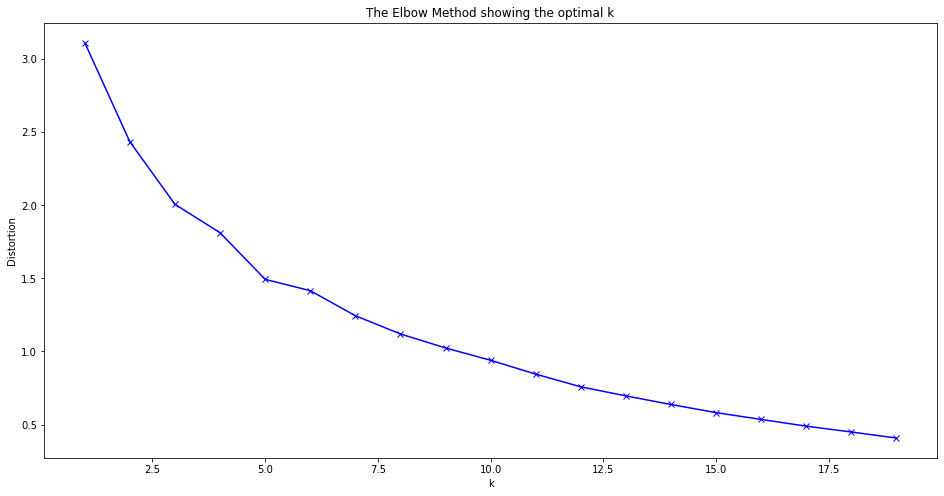

In [14]:
plt.figure(figsize=(16,8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

Using the elbow method, the optimum <b>kvalue is 5</b> where the slope is sharply changing

In [15]:
#Setting the number of clusters
kclusters = 5

toronto_grouped_clustering = toronto_group.drop("Neighborhood", 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32)

In [16]:
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

toronto_merged = toronto

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
toronto_merged = toronto_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

print("Merged Toronto Size : ",toronto_merged.shape)
toronto_merged.head()

Merged Toronto Size :  (39, 16)


,Postalcode,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
37,M4E,East Toronto,The Beaches,43.676357,-79.293031,0,Trail,Health Food Store,Pub,Dog Run,Department Store,Dessert Shop,Diner,Discount Store,Distribution Center,Yoga Studio
41,M4K,East Toronto,"The Danforth West, Riverdale",43.679557,-79.352188,1,Greek Restaurant,Italian Restaurant,Coffee Shop,Ice Cream Shop,Furniture / Home Store,Restaurant,Indian Restaurant,Spa,Juice Bar,Brewery
42,M4L,East Toronto,"India Bazaar, The Beaches West",43.668999,-79.315572,1,Fast Food Restaurant,Gym,Pet Store,Brewery,Sandwich Place,Burrito Place,Restaurant,Pub,Pizza Place,Park
43,M4M,East Toronto,Studio District,43.659526,-79.340923,1,Café,Coffee Shop,Bakery,Gastropub,American Restaurant,Brewery,Bar,Ice Cream Shop,Fish Market,Italian Restaurant
44,M4N,Central Toronto,Lawrence Park,43.728020,-79.388790,3,Park,Bus Line,Swim School,Yoga Studio,Department Store,Event Space,Ethiopian Restaurant,Electronics Store,Eastern European Restaurant,Donut Shop


In [17]:
#Install Geopy

!pip install geopy
from geopy.geocoders import Nominatim

In [18]:
address = 'Toronto, CA'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Manhattan are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Manhattan are 43.6534817, -79.3839347.


<b>Creating Folium Map<b>

In [19]:
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=12)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged['Latitude'], toronto_merged['Longitude'], toronto_merged['Neighborhood'], toronto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters